### Лабораторна робота. Класичні методи побудови рекомендацій. Частина 1

У лабораторній вам потрібно буде реалізувати кілька метрик, застосувати популярні моделі та оцінити вплив гіперпараметрів на якість рекомендацій.

### Формат здачі завдання
Кожне завдання має супроводжуватися текстом з висновками. Додайте візуалізації результатів, наприклад, у завданнях порівняння якості при різних гіперпараметрах. Постарайтеся робити код лаконічним та зрозумілим для тих, хто перевіряє.

Фіксуйте random seed для відтворення результатів.


### Оцінювання
За лабораторну можна здобути максимум 20 балів. Передбачається, що обчислювальних ресурсів Google Colab вистачить для успішного виконання роботи.

### Загальна інформація про завдання
У лабораторній роботі використовуватиметься класичний датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), що містить оцінки фільмів користувачами та ознаки користувачів та фільмів.

Для всіх завдань, що з генерацією рекомендацій, $K=20$, тобто. Вам необхідно підготувати 20 рекомендацій для кожного користувача.

Так як датасет з області кіно, і нам дано інформацію про оцінки, необхідно виконувати фільтрацію переглянутих айтемів при генерації рекомендацій.

Ми будемо розділяти датасет на 2 частини, train та validation, оскільки метою завдань є наочна оцінка впливу ключових гіперпараметрів (кількість сусідів/латентних факторів) на якість. Якщо ви підбиратимете інші гіперпараметри моделей (коефіцієнти регуляризації в als, коефіцієнти K1 і B bm25), відокремте самостійно частину train для підбору параметрів, а підсумкову якість оцінюйте після підбору параметрів на validation. Підбір гіперпараметрів можна реалізувати, наприклад за допомогою optuna.

In [11]:
# !pip install seaborn

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
K = 20
SEED = 666
np.random.seed(SEED)

## Знайомство з даними

## Завдання 1

**(2 бали) Завдання 1.** Знайомство з даними.
Проаналізуйте, наскільки активно користувачі залишають оцінки, наскільки активно фільми отримують оцінки, які переважають, як змінюється кількість оцінок у часі. Напишіть свої результати.

In [3]:
!pip install rs-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 29.3 MB/s eta 0:00:00


In [4]:
from rs_datasets import MovieLens

In [5]:
data = MovieLens("1m")
data.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 17.3MB/s]                            


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [22]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(15)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59
8,1,594,4,2000-12-31 22:37:48
9,1,919,4,2000-12-31 22:22:48


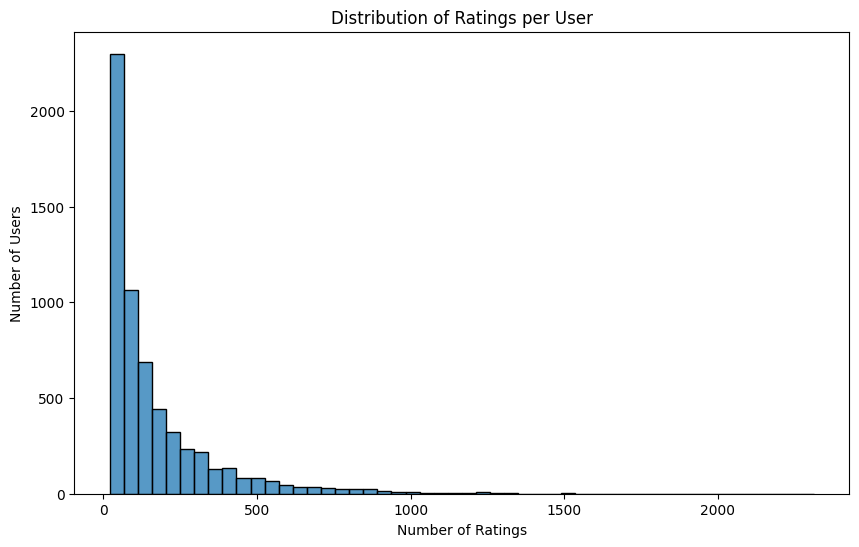

In [21]:
user_counts = reviews['user_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_counts, bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Бачимо що зі збільшенням кількості оцінок для одного користувача, зменшується кількість користувачів. Іншими словами, дуже багато користувачів залишили менше 250 відгуків на фільми.

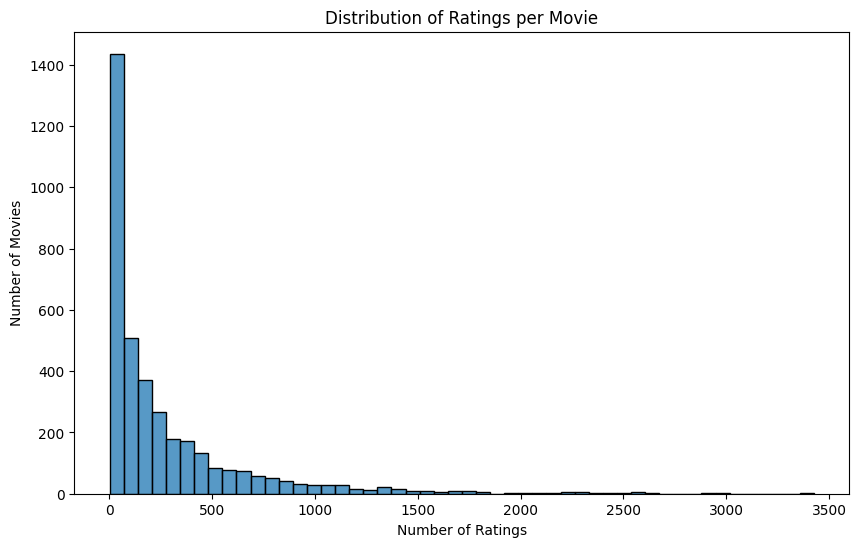

In [20]:
movie_counts = reviews['item_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(movie_counts, bins=50)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

Більшість фільмів має мало оцінок.

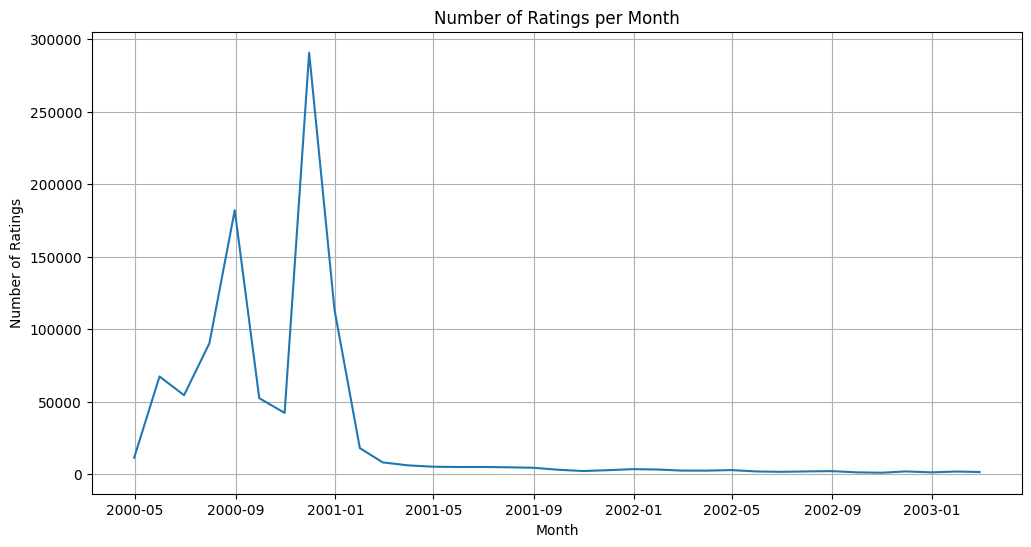

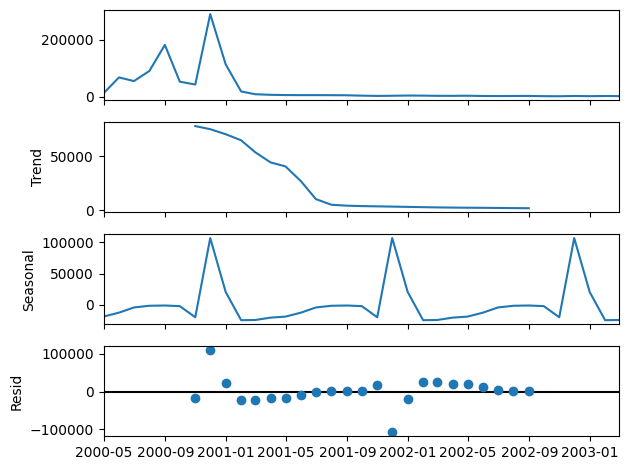

In [19]:
# Ratings over time analysis
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
monthly_ratings = reviews.groupby(pd.Grouper(key='timestamp', freq='ME')).size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings)
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

# Decompose time series
decomposition = seasonal_decompose(monthly_ratings)
fig = decomposition.plot()
plt.show()

Бачимо із першого графіка, що кількість відгуків ближче до зимових канікул (грудень-січень місяць).

Використовуючи `seasonal_decompose(...)` ми "розбираємо" наш часовий ряд на такі атрибути: Трендовий, Сезоннний та Залишковий.
Де
- трендовий атрибут, розказує нам про закономірність часового ряду,
- сезонний атрибут, розказує про періодичність часового ряду,
- залишковий атрибут, розказує про ті моменти часового ряду, які не можуть пояснити перші два атрибути (трендовий та сезонний). Це можуть бути певні коливання, шуми, зміни які не мають періодичності або закономірності.

## Завдання 2
**(2 бали) Завдання 2.**
Фільтрування та розбиття даних

Використовуватимемо global time split, тобто. відокремимо train та validation за обраною датою.

Реалізуйте таке розбиття:

1) дані до 1 грудня 2000 року не включаючи - дані train

2) дані з 1 грудня 2000 року включно до 31 грудня 2000 року включно – валідаційні дані.

У валідаційних даних повинні залишитися лише позитивні оцінки (хочемо передбачити, що сподобається користувачеві). Будемо вважати позитивними оцінки > 3. Видалимо з валідаційної вибірки холодних користувачів, оскільки більшість алгоритмів, що розглядаються, не генерують рекомендації для холодних користувачів.

In [28]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    data_length = log.shape[0]
    num_users = log[user_id].nunique()
    num_items = log[item_id].nunique()

    print(f"DataSet length = {data_length},\nNumber of users = {num_users},\nNumber of items = {num_items}")

In [29]:
# YOUR CODE HERE
import pandas as pd

data.ratings['timestamp'] = pd.to_datetime(data.ratings['timestamp'], unit='s')

train_end_date = pd.to_datetime('2000-12-01')
validation_end_date = pd.to_datetime('2000-12-31')

train_data = data.ratings[data.ratings['timestamp'] < train_end_date]

validation_data = data.ratings[
    (data.ratings['timestamp'] >= train_end_date) & (data.ratings['timestamp'] <= validation_end_date) & (
            data.ratings['relevance'] > 3)]

cold_users = set(validation_data['user_id']) - set(train_data['user_id'])

validation_data = validation_data[~validation_data['user_id'].isin(cold_users)]

train_data.to_csv('train_data.csv', index=False)
validation_data.to_csv('validation_data.csv', index=False)

In [31]:
assert train_data.shape[0] == 791270
assert validation_data.shape[0] == 14790

In [32]:
get_log_info(train_data)

DataSet length = 791270,
Number of users = 5365,
Number of items = 3662


In [33]:
get_log_info(validation_data)

DataSet length = 14790,
Number of users = 522,
Number of items = 2341


## Завдання 3
**(2 бали) Завдання 3.** Базове рішення.

Рекомендуємо для кожного користувача з val 20 випадкових фільмів. Датасет з рекомендаціями повинен містити колонки user_id, item_id, relevance.

In [34]:
%%time
# YOUR CODE HERE
K = 20

unique_users = validation_data['user_id'].unique()

np.random.seed(666)
random_recommendations = []
for user in unique_users:
    random_items = np.random.choice(validation_data['item_id'].unique(), size=K, replace=False)
    user_recs = [(user, item, 1) for item in random_items]
    random_recommendations.extend(user_recs)

random_pred = pd.DataFrame(random_recommendations, columns=['user_id', 'item_id', 'relevance'])

CPU times: user 251 ms, sys: 0 ns, total: 251 ms
Wall time: 253 ms


In [35]:
assert random_pred.shape[0] == validation_data['user_id'].nunique() * K

In [36]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,314,1


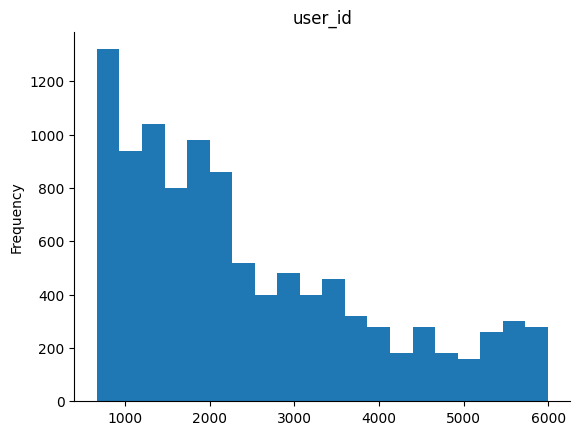

In [37]:
# @title user_id

from matplotlib import pyplot as plt
random_pred['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Завдання 4
**(5 бал) Завдання 4.** Метрики якості.


Використовуйте наступний набір метрик якості:
- NDCG@K (необхідно реалізувати)
- HitRate@K (можна взяти з семінару або використати готову реалізацію)
- Coverage@K (можна взяти з семінару або використати готову реалізацію)
- Surprisal@K (необхідно реалізувати)

1) Реалізуйте метрики NDCG@K, Surprisal@K **(2 бали)**

2) **(1 бал)** Створіть функцію, яка генерує словник/dataframe з 4 метриками за наданим рішенням. Оцініть baseline-рішення на валідації


Не забудьте, що ми можемо рахувати метрику для різних значень k (наприклад, спочатку підготували 10 рекомендацій, а вважаємо метрику для k = 1, 5, 10). У цьому випадку при підрахунку метрики використовуються перші top-k рекомендації та всі релевантні айтеми з ground truth.

Будемо використовувати такі позначення у формулах:
- $i$ – ідентифікатор користувача, ціле число від 1 до N
- $j$ – позиція товару у списку рекомендацій для користувача $i$, ціле число від 1 до K
- $N$ – кількість користувачів
- $K$ – кількість айтемів у списку рекомендацій, для якого розраховується метрика
- $\mathbb{1}_{r_{ij}}$ - індикаторна функція, факт придбання користувачем i продукту на позиції j у списку рекомендацій
- $|Rel_i|$ - кількість айтемів, з якими були позитивні взаємодії у користувача $i$ у тестовому періоді

### NDCG

Реалізуйте бінарну версію метрики NDCG (Normalized Discounted Cumulative Gain) з метою оцінки якості ранжування. У банірній версії фактичні значення релевантності у ground truth ігноруються, використовується лише інофрація про факт позитивної взаємодії.

1) Порахуємо DCG

$$DCG\@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Щоб отримати Normalized метрику, обчислимо максимально можливе для цього користувача значення $DCG\@K$, $IDCG\@K$.

$$IDCG\@K(i) = max(DCG\@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\ log_2 (j+1)}$$

$$nDCG\@K(i) = \frac{DCG\@K(i)}{IDCG\@K(i)}$$

3) Результат середнім користувачам.

$$ nDCG\@K = \frac{\sum_{i=1}^{N}nDCG\@K(i)}{N}$$

#### NDCG для одного користувача

In [38]:
import math
import numpy as np

In [39]:
def ndcg_user(row, k):
    """
    Calculates NDCG@K for a single user.

    Args:
        row: Row of DataFrame with columns 'pred_list' (predictions) and 'gt_list' (ground truth ratings).
        k: Number of recommendations to consider.

    Returns:
        float: NDCG@K value.
    """
    pred_list = row['pred_list'][:k]  # Take top-k predictions
    gt_list = set(row['gt_list'])  # Transform ground truth into a set for fast lookup

    # Calculate DCG using the indicator function
    dcg = sum((1 if pred in gt_list else 0) / np.log2(j + 2) for j, pred in enumerate(pred_list))

    # Calculate IDCG (maximum DCG)
    idcg = sum(1 / np.log2(j + 2) for j in range(min(k, len(gt_list))))

    # Calculate nDCG
    ndcg = dcg / idcg if idcg > 0 else 0
    return ndcg

In [40]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296,
                    abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246,
                    abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0.,
                    abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

#### NDCG для всіх користувачів

In [41]:
# YOUR CODE HERE: оцінка NDCG для всіх користувачів. На вхід приходять рекомендації у форматі як у завданні 3
def average_ndcg(df, k):
    ndcgs = df.apply(lambda row: ndcg_user(row, k), axis=1)
    return ndcgs.mean()

In [48]:
df = pd.DataFrame([
    {'user_id': 4, 'pred_list': [2, 3, 4], 'gt_list': [1, 2, 3, 5]},
    {'user_id': 5, 'pred_list': [5, 6, 1], 'gt_list': [2, 3, 4]},
    {'user_id': 6, 'pred_list': [2, 4, 6], 'gt_list': [1, 3, 5, 6]}
])

average_ndcg_score = average_ndcg(df, k=3)
print(f"Average NDCG@K for all users: {average_ndcg_score:.4f}")

Average NDCG@K for all users: 0.3333


#### Surprisal
Подивимося, наскільки наші рекомендації є гарними з погляду новизни для користувача. Як новизну розглядатимемо "непопулярність" айтемів у рекомендаціях.

1. Розглянемо власну інформацію item-а як міру його новизни для користувачів.

 $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
 де $i$ - об'єкт (item), $N$ - кількість користувачів в навчальній вибірці, $|u_i|$ - кількість користувачів, що взаємодіяли з об'єктом $i$ в навчальній вибірці.


2. Власна інформація визначається для item-а, а значення метрики ми хочемо вважати для користувача $k$ - кількості рекомендацій. Для підрахунку Surprisal користувача є середнім значення власної інформації в топ-k рекомендаціях цього користувача.

 Щоб отримати значення від 0 до 1, розділимо значення метрики для користувача максимально можливо значення метрики дорівнює $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат середнім користувачам.

Що робити з холодними елементами при підрахунку $selfInformation$? Найпростіший варіант — вважати, що для них була взаємодія з одним користувачем.

Зауважте, що self information можна розрахувати один раз при ініціалізації метрики. Можливо, цю метрику варто зробити класом.

In [50]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.N = log['user_id'].nunique()

        item_interaction_counts = log.groupby('item_id')['user_id'].nunique()

        self.self_information = {}
        for item, count in item_interaction_counts.items():
            self.self_information[item] = -np.log2(count / self.N)

    def __call__(self, pred, k):
        top_k_items = pred['item_id'].values[:k]
        total_self_info = 0

        for item in top_k_items:
            item_self_info = self.self_information.get(item, -np.log2(1 / self.N))
            total_self_info += item_self_info

        surprisal_value = total_self_info / (k * np.log2(self.N))

        return surprisal_value

In [51]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))

assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685,
                    abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=4),
                    # k=2: !=
                    (0.684 + 0.5) / 2, abs_tol=1e-3)

In [ ]:
# YOUR CODE HERE:


 оцінка 4 метрик для рекомендацій із завдання 3

## Create a function that generate DS

In [52]:
def generate_dataset(num_users=5, num_items=10):
    np.random.seed(666)
    user_ids = np.arange(num_users)
    item_ids = np.arange(num_items)

    interactions = []
    for user in user_ids:
        interacted_items = np.random.choice(item_ids, size=np.random.randint(1, 6), replace=False)
        for item in interacted_items:
            interactions.append({'user_id': user, 'item_id': item})

    interactions_df = pd.DataFrame(interactions)

    recommendations = []
    for user in user_ids:
        recommended_items = np.random.choice(item_ids, size=3, replace=False)
        recommendations.append({'user_id': user, 'pred_list': recommended_items.tolist(),
                                'gt_list': interactions_df[interactions_df['user_id'] == user]['item_id'].tolist()})

    recommendations_df = pd.DataFrame(recommendations)

    return recommendations_df, interactions_df

In [66]:
random_pred, reviews = generate_dataset(4, 8)
display(random_pred)
reviews

,user_id,pred_list,gt_list
0,0,"[0, 7, 1]","[0, 3, 7, 6, 4]"
1,1,"[1, 5, 4]","[3, 5, 6, 2, 0]"
2,2,"[7, 5, 1]","[1, 2, 0]"
3,3,"[5, 1, 4]","[5, 1, 6, 3, 2]"


,user_id,item_id
0,0,0
1,0,3
2,0,7
3,0,6
4,0,4
5,1,3
6,1,5
7,1,6
8,1,2
9,1,0


## DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

In [62]:
def hit_rate_at_k(predictions_df, k):
    hits = 0
    total = 0

    for _, row in predictions_df.iterrows():
        hits += len(set(row['pred_list'][:k]) & set(row['gt_list']))
        total += k

    return hits / total

In [63]:
def coverage_at_k(predictions_df, k, all_items):
    recommended_items = set()

    for _, row in predictions_df.iterrows():
        recommended_items.update(row['pred_list'][:k])

    return len(recommended_items) / len(all_items)

In [64]:
def evaluate_metrics(predictions_df, log_df, k):
    results = []

    surprisal_calculator = Surprisal(log_df)
    all_items = set(log_df['item_id'].unique())

    for _, row in predictions_df.iterrows():
        user_id = row['user_id']
        ndcg_value = ndcg_user(row, k)
        hit_rate = hit_rate_at_k(predictions_df, k)
        pred_df = pd.DataFrame({'item_id': row['pred_list']})
        surprisal_value = surprisal_calculator(pred_df, k)
        coverage_value = coverage_at_k(predictions_df, k, all_items)

        results.append({
            'NDCG@K': ndcg_value,
            'HitRate@K': hit_rate,
            'Coverage@K': coverage_value,
            'Surprisal@K': surprisal_value
        })

    return pd.DataFrame(results).mean()

In [68]:
metrics_df = evaluate_metrics(random_pred, reviews, k=20)
metrics_df

,0
NDCG@K,0.388730
HitRate@K,0.075000
Coverage@K,0.625000
Surprisal@K,0.096344


## Завдання 5
**(5 балів) Завдання 5.** item-based knn

1) **(2 бали)** Застосуйте [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) з бібліотеки [implicit](https://github.com/benfred/implicit). Оцініть вплив кількості сусідів (параметр K) на якість рекомендацій (за 4 реалізованими метриками). Побудуйте графік залежності NDCG@20 від сусідів.

2) **(2 бали)** Розберіться, в чому полягає ідея використання ваг tfidf і bm25, наприклад, за цією статтею(https://www.benfrederickson.com/distance-metrics/). Виберіть один із способів (tfidf або bm25) зважування, опишіть основну ідею текстом. Застосуйте обрану модель, підберіть гіперпараметри на відкладених даних (розбийте самостійно) та оцініть якість на val-датасеті.

3) **(1 бал)** Повторіть експеримент, використовуючи для навчання тільки позитивні оцінки (> 3). Не забудьте при фільтрації переглянутих врахувати всі взаємодії (не лише позитивні). Як це вплинуло на якість?

Чи вдалось досягти кращої якості, ніж з використанням Cosine?

In [69]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 28.5 MB/s eta 0:00:00


In [70]:
from implicit.nearest_neighbours import CosineRecommender
from scipy.sparse import csr_matrix

In [71]:
def cosine_recommender(train_data, k):
    user_item_matrix = pd.pivot_table(train_data, values='relevance', index='user_id', columns='item_id').fillna(0)
    user_item_matrix = csr_matrix(user_item_matrix.values)

    model = CosineRecommender(K=k)
    model.fit(user_item_matrix, show_progress=False)

    user_ids = train_data['user_id'].unique()
    recommendations = []

    for user_id in user_ids:
        user_index = np.where(user_ids == user_id)[0][0]
        recommended_items, scores = model.recommend(user_index, user_item_matrix[user_index], N=20)
        recommendations.extend([(user_id, item, score) for item, score in zip(recommended_items, scores)])

    return pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])

In [72]:
def ndcg_user(row, k):
    pred_list = row['pred_list'][:k]
    gt_list = set(row['gt_list'])

    dcg = sum((1 if pred in gt_list else 0) / np.log2(j + 2) for j, pred in enumerate(pred_list))
    idcg = sum(1 / np.log2(j + 2) for j in range(min(k, len(gt_list))))

    ndcg = dcg / idcg if idcg > 0 else 0
    return ndcg

In [73]:
def average_ndcg(pred, valid, k):
    score = 0
    for uid in pred['user_id'].unique():
        user_row = pd.Series({
                'pred_list': pred[pred['user_id'] == uid]['item_id'],
                'gt_list': valid[valid['user_id'] == uid]['item_id']
            })
        score += ndcg_user(user_row, k)
    return score

In [74]:
recomendation = cosine_recommender(train_data, k=20)

In [75]:
ndcg_score = average_ndcg(recomendation, validation_data, k=20)

print(f'NGCG@20: {ndcg_score}')

NGCG@20: 6.45664416696819


In [80]:
ndcg_20 = {}
for k in range(1, amount := 22):
  print(f"{k}|{amount-1} -> {round(k/(amount-1) * 100, 2)}%")
  ndcg_20[k] = average_ndcg(cosine_recommender(train_data, k=k), validation_data, 20)

1|21 -> 4.76%
2|21 -> 9.52%
3|21 -> 14.29%
4|21 -> 19.05%
5|21 -> 23.81%
6|21 -> 28.57%
7|21 -> 33.33%
8|21 -> 38.1%
9|21 -> 42.86%
10|21 -> 47.62%
11|21 -> 52.38%
12|21 -> 57.14%
13|21 -> 61.9%
14|21 -> 66.67%
15|21 -> 71.43%
16|21 -> 76.19%
17|21 -> 80.95%
18|21 -> 85.71%
19|21 -> 90.48%
20|21 -> 95.24%
21|21 -> 100.0%


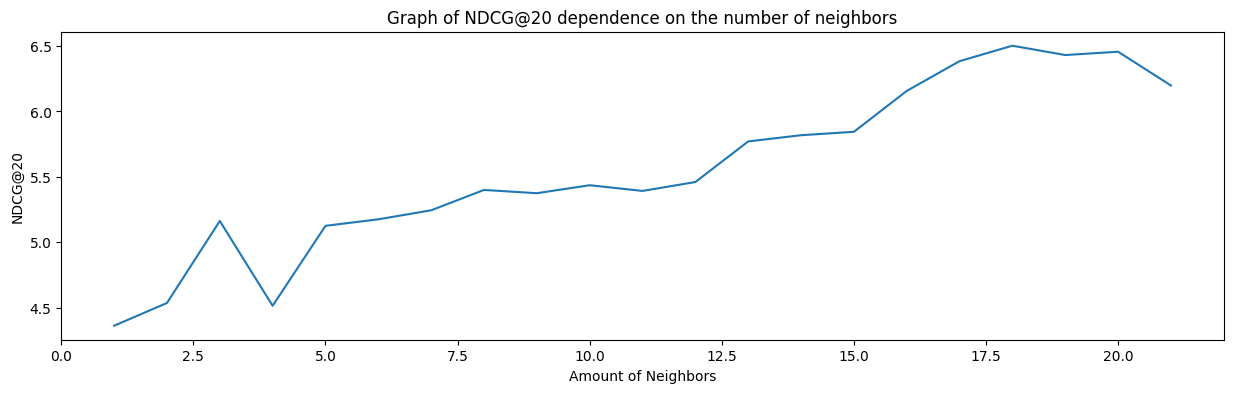

In [81]:
plt.figure(figsize=(15,4))
plt.plot(ndcg_20.keys(), ndcg_20.values())
plt.xlabel("Amount of Neighbors")
plt.ylabel("NDCG@20")
plt.title("Graph of NDCG@20 dependence on the number of neighbors")

plt.show()

## Ідея tfidf
`tfidf (term frequency inverse document frequency)` є метрикою, що використовується для оцінки важливості терміна у документі в контексті колекції документів або корпусу. Вона обчислюється як добуток двох компонентів:

`tf (term frequency)`: частота терміна в документі, що показує, наскільки часто термін зустрічається в даному документі.

`idf (inverse document frequency)`: обернена частота документів, що містять термін, що відображає, наскільки термін рідкісний у всьому корпусі.

Формула для `tfidf`:

$$ tfidf(t, d) = tf(t, d) \times idf(t, D)$$
$$tf(t, d) = \frac{слово\,(t)}{документ\,(d)}$$
$$idf(t, D) = \log\frac{|D|}{|\{d: d\in D,\,t\in d\}|}$$
де:
- $t$ — термін,
- $d$ — документ,
- $D$ — cукупність документів.
Це дозволяє термінам, які часто зустрічаються в одному документі, але рідко — в інших, отримувати вищу вагу.

## Ідея BM25
`bm25` базується на покращеній моделі `tfidf`, яка враховує специфіку текстів різної довжини та загальну рідкість термінів. `bm25` також використовує параметри налаштування, що керують важливістю рідкісних термінів та коригують частоту взаємодій з кожним елементом (у нашому випадку – взаємодію користувача з певним товаром).

`bm25` розраховує вагу за формулою, яка має додаткові параметри, що дозволяють регулювати вплив кожного з термінів:


$$BM25(q,d) = \sum_{t\in q}\log\left(\frac{N-n_t+0.5}{n_t+0.5}+1\right)\cdot\frac{(k_1+1)\cdot f_{t,\,d}}{f_{t,\,d}+k_1\cdot\left(1-b+b\cdot\frac{|d|}{avg(|d|)}\right)}$$

де:
- $N$ - загальна кількість документів (користувачів),
- $n_t$ - кількість документів, що містять термін $t$,
- $f_{t,\,d}$ - частота терміна $t$ в документі $d$,
- $k_1, b$ - гіперпараметри, які потрібно підібрати для коректного застосування моделі.

In [82]:
from implicit.nearest_neighbours import BM25Recommender
from sklearn.model_selection import train_test_split

In [83]:
def bm25_recommender(train_data, k, k1=1.2, b=0.75):
    df = train_data[:10000]
    user_item_matrix = pd.pivot_table(df, values='relevance', index='user_id', columns='item_id').fillna(0)
    user_item_matrix = csr_matrix(user_item_matrix.values)

    user_ids = df['user_id'].unique()
    recommendations = pd.DataFrame({'user_id': [], 'item_id': [], 'relevance': []})

    for i, user_id in enumerate(user_ids):
        model = BM25Recommender(K=k, K1=k1, B=b)
        model.fit(user_item_matrix, show_progress=False)

        recommended_items, scores = model.recommend(i, user_item_matrix[i], N=20)
        recommendations_temp = pd.DataFrame({'user_id': user_id, 'item_id': recommended_items, 'relevance': scores})
        recommendations = pd.concat([recommendations, recommendations_temp])

    return recommendations

In [84]:
train_set, test_set = train_test_split(train_data, test_size=0.15, random_state=666)

In [85]:
param_scores = {}
for k1 in [1.0, 1.2, 1.5]:
    for b in [0.5, 0.75, 1.0]:
        rec = bm25_recommender(train_set, k=20, k1=k1, b=b)
        score = average_ndcg(rec, test_set, k=20)
        param_scores[(k1, b)] = score
        print(f"k1={k1}, b={b}, NDCG@20: {score}")

k1=1.0, b=0.5, NDCG@20: 27.373363436053097
k1=1.0, b=0.75, NDCG@20: 27.01207854134322
k1=1.0, b=1.0, NDCG@20: 26.711142808089445
k1=1.2, b=0.5, NDCG@20: 27.159518554724738
k1=1.2, b=0.75, NDCG@20: 26.715203093778644
k1=1.2, b=1.0, NDCG@20: 26.701555641417528
k1=1.5, b=0.5, NDCG@20: 27.204199559352308
k1=1.5, b=0.75, NDCG@20: 26.991960588986668
k1=1.5, b=1.0, NDCG@20: 26.783823937579367


In [86]:
best_params = max(param_scores, key=param_scores.get)
print(f"The best params: k1={best_params[0]}, b={best_params[1]}")

The best params: k1=1.0, b=0.5


In [87]:
bm25_rec = bm25_recommender(train_data, k=20, k1=best_params[0], b=best_params[1])
ndcg_score = average_ndcg(bm25_rec, validation_data, k=20)
print(f"NDCG@20: {ndcg_score}")

NDCG@20: 0.10229526794987165


In [89]:
ndcg_results = {}
for k in range(1, amount := 22):
  print(f"{k}|{amount-1} -> {round(k/(amount-1) * 100, 2)}%")
  rec = bm25_recommender(train_data, k=k, k1=best_params[0], b=best_params[1])
  ndcg_results[k] = average_ndcg(rec, validation_data, 20)

1|21 -> 4.76%
2|21 -> 9.52%
3|21 -> 14.29%
4|21 -> 19.05%
5|21 -> 23.81%
6|21 -> 28.57%
7|21 -> 33.33%
8|21 -> 38.1%
9|21 -> 42.86%
10|21 -> 47.62%
11|21 -> 52.38%
12|21 -> 57.14%
13|21 -> 61.9%
14|21 -> 66.67%
15|21 -> 71.43%
16|21 -> 76.19%
17|21 -> 80.95%
18|21 -> 85.71%
19|21 -> 90.48%
20|21 -> 95.24%
21|21 -> 100.0%


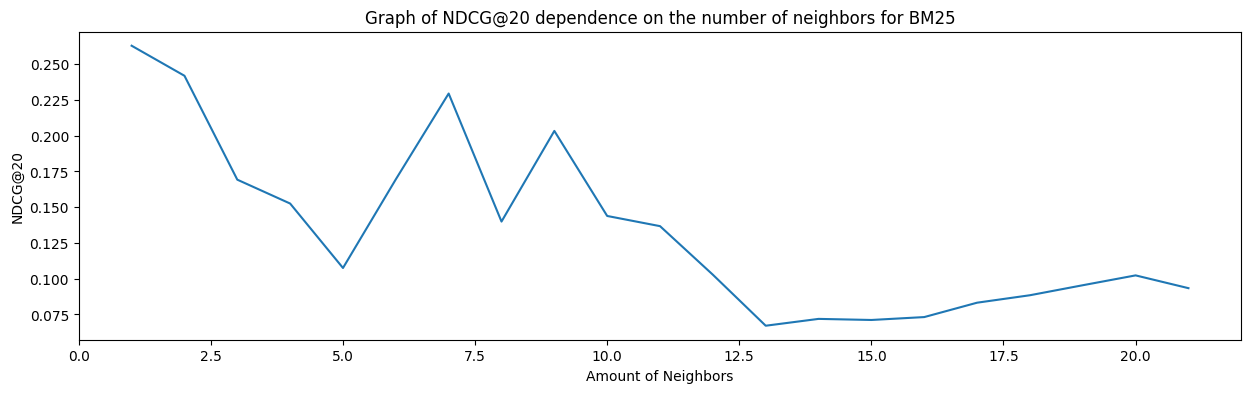

In [90]:
plt.figure(figsize=(15, 4))
plt.plot(ndcg_results.keys(), ndcg_results.values())
plt.xlabel("Amount of Neighbors")
plt.ylabel("NDCG@20")
plt.title("Graph of NDCG@20 dependence on the number of neighbors for BM25")
plt.show()

## Завдання 6. ALS (4 бали)

1) **(2 бали)** Застосуйте ALS із бібліотеки [implicit](https://github.com/benfred/implicit), використовуючи для навчання всі оцінки. Оцініть залежність якості рекомендацій (по 4 реалізованих метриках) кількості факторів (параметр factors). Побудуйте графік залежності NDCG@20 від сусідів.

2) **(2 бали)** Повторіть експеримент із пункту 1, використовуючи для навчання лише позитивні оцінки (> 3). Не забудьте при фільтрації переглянутих врахувати всі взаємодії (не лише позитивні). Як це вплинуло на якість?

Зверніть увагу на наявність регуляризації в параметрах моделі. Для досягнення хорошої якості моделі необхідно підбирати кількість факторів і рівень регулювання одночасно на відкладеній вибірці, наприклад, з використанням [optuna](https://optuna.org/).

In [91]:
from implicit.als import AlternatingLeastSquares

In [92]:
def als_recommender(train_data, factors, regularization=0.1, iterations=15):
    df = train_data[:10000]
    user_item_matrix = pd.pivot_table(df, values='relevance', index='user_id', columns='item_id').fillna(0)
    user_item_matrix = csr_matrix(user_item_matrix.values)

    model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
    model.fit(user_item_matrix, show_progress=False)

    user_ids = df['user_id'].unique()
    recommendations = pd.DataFrame({'user_id': [], 'item_id': [], 'relevance': []})

    for i, user_id in enumerate(user_ids):
        recommended_items, scores = model.recommend(i, user_item_matrix[i], N=20)
        recommendations_temp = pd.DataFrame({'user_id': user_id, 'item_id': recommended_items, 'relevance': scores})
        recommendations = pd.concat([recommendations, recommendations_temp])

    return recommendations

In [95]:
train_set, test_set = train_test_split(train_data, test_size=0.15, random_state=666)
factor_scores = {}

for factors in range(1, amount := 51, 4):
    rec = als_recommender(train_set, factors=factors)
    score = average_ndcg(rec, test_set, k=20)
    factor_scores[factors] = score
    print(f"Factors {factors}|{amount} -> NDCG@20: {score}")

Factors 1|51 -> NDCG@20: 22.30576846685164
Factors 5|51 -> NDCG@20: 31.676564510894742
Factors 9|51 -> NDCG@20: 27.443214624594276
Factors 13|51 -> NDCG@20: 27.42836312310993
Factors 17|51 -> NDCG@20: 29.657309238362988
Factors 21|51 -> NDCG@20: 29.38454878208957
Factors 25|51 -> NDCG@20: 32.46077117679074
Factors 29|51 -> NDCG@20: 28.290868645906308
Factors 33|51 -> NDCG@20: 31.162549903837643
Factors 37|51 -> NDCG@20: 31.00657846983475
Factors 41|51 -> NDCG@20: 30.293848170784266
Factors 45|51 -> NDCG@20: 29.195907158610247
Factors 49|51 -> NDCG@20: 32.66054196177003


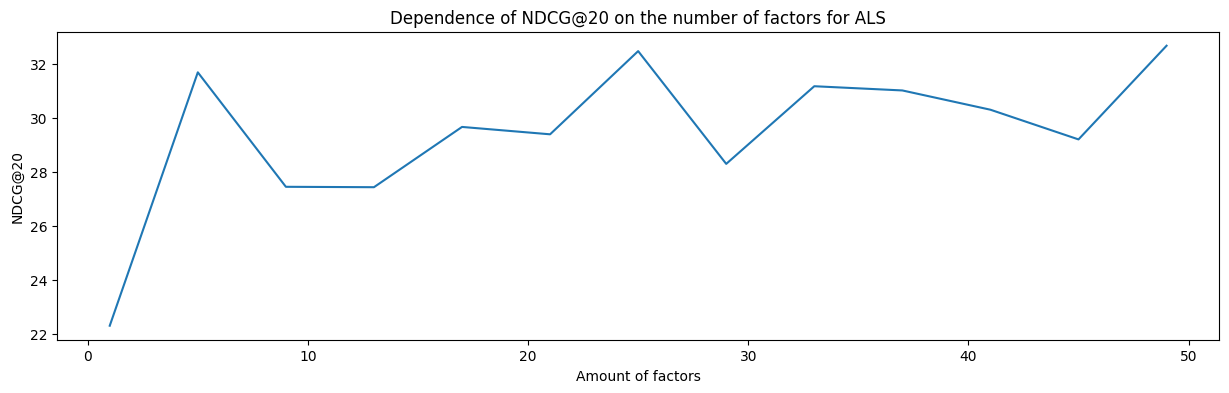

In [96]:
plt.figure(figsize=(15, 4))
plt.plot(factor_scores.keys(), factor_scores.values())
plt.xlabel("Amount of factors")
plt.ylabel("NDCG@20")
plt.title("Dependence of NDCG@20 on the number of factors for ALS")
plt.show()

## Only positive ratings (> 3)

In [98]:
train_data_positive = train_data[train_data['relevance'] > 3]
user_item_matrix_positive = pd.pivot_table(train_data, values='relevance', index='user_id', columns='item_id').fillna(0)
user_item_matrix_positive = csr_matrix(user_item_matrix_positive.values)

factor_scores_positive = {}

for factors in range(1, amount := 51, 4):
    model = AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=15)
    model.fit(user_item_matrix_positive, show_progress=False)

    rec = als_recommender(train_data_positive, factors=factors)
    score = average_ndcg(rec, test_set, k=20)
    factor_scores_positive[factors] = score
    print(f"Factors {factors}|{amount} -> NDCG@20: {score}")

Factors 1|51 -> NDCG@20: 0.9762722886066182
Factors 5|51 -> NDCG@20: 0.65383326884166
Factors 9|51 -> NDCG@20: 0.8239217000907754
Factors 13|51 -> NDCG@20: 0.7399595783715178
Factors 17|51 -> NDCG@20: 0.2199541253667577
Factors 21|51 -> NDCG@20: 0.7268660144894178
Factors 25|51 -> NDCG@20: 0.6422079911903896
Factors 29|51 -> NDCG@20: 0.5896533408540279
Factors 33|51 -> NDCG@20: 0.680102213991535
Factors 37|51 -> NDCG@20: 0.501509708375109
Factors 41|51 -> NDCG@20: 0.48229920135669824
Factors 45|51 -> NDCG@20: 0.8023474302519751
Factors 49|51 -> NDCG@20: 0.5185612938708735


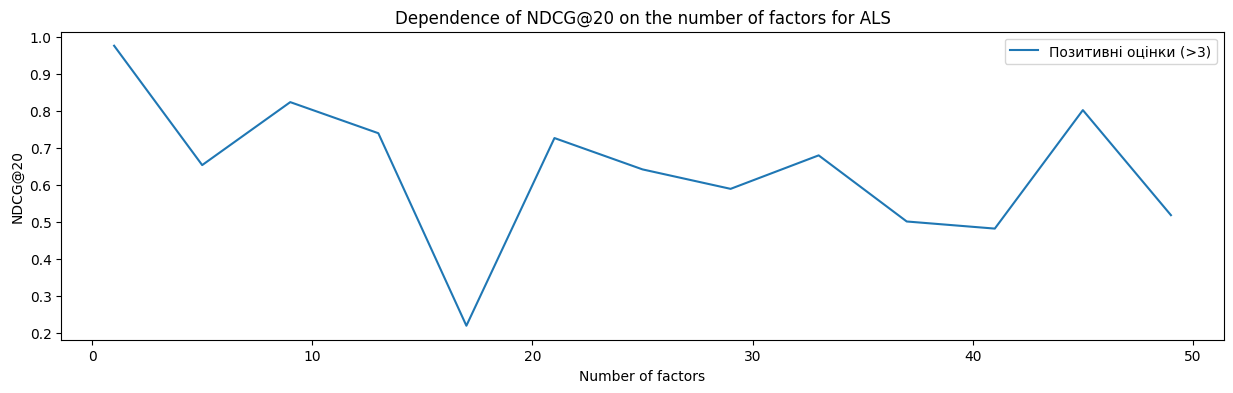

In [99]:
plt.figure(figsize=(15, 4))
plt.plot(factor_scores_positive.keys(), factor_scores_positive.values(), label='Позитивні оцінки (>3)')
plt.xlabel("Number of factors")
plt.ylabel("NDCG@20")
plt.title("Dependence of NDCG@20 on the number of factors for ALS")
plt.legend()
plt.show()

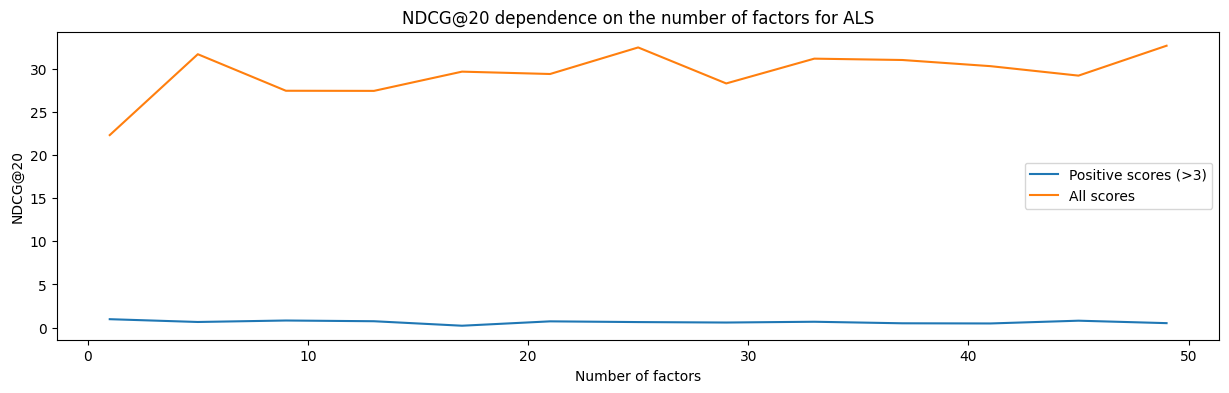

In [101]:
plt.figure(figsize=(15, 4))
plt.plot(factor_scores_positive.keys(), factor_scores_positive.values(), label='Positive scores (>3)')
plt.plot(factor_scores.keys(), factor_scores.values(), label='All scores')
plt.xlabel("Number of factors")
plt.ylabel("NDCG@20")
plt.title("NDCG@20 dependence on the number of factors for ALS")
plt.legend()
plt.show()

# Підготуйте висновки по всьому ноутбуку
Які моделі працювали краще? Які на це можуть бути причини? Які моделі найбільш чутливі до налаштування гіперпараметрів? Розкажіть про цікаві спостереження та труднощі.